In [1]:
import warnings

import numpy as np
import pandas as pd
import quantstats as qs
import yfinance as yf
from IPython.display import clear_output

warnings.filterwarnings('ignore')
pd.options.display.width = 1000

In [2]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500_tickers = list(sp500.Symbol)
sp500_tickers = [e for e in sp500_tickers if e not in ('BRK.B','BF.B')]

# len(sp500_tickers)
# sp500.head(5)

In [3]:
# %%time

data_sp500 = yf.download(sp500_tickers, start='2000-01-01', end='2021-01-01')['Adj Close']

# Filtramos los datos y nos quedamos únicamente con aquellos que tengan más de 1250 datos (5 años)
conteo = pd.DataFrame(data_sp500.count(), columns=['Q'])
sp500_tickers = list(conteo.loc[conteo.Q>1250].index)

pd.options.display.max_columns = 6
# data_sp500.head()

[*********************100%***********************]  503 of 503 completed


In [4]:
# Cantidad de tickers analizados
len(sp500_tickers)

490

In [5]:
w_min, w_max = 0.05, 0.5  
n_stocks = 5

ponds = np.random.dirichlet(np.ones(n_stocks), 100)
oks = [w for w in ponds if (w.min()>w_min) & (w.max()<w_max)]

In [6]:
# TODO GUILLE
# meses = pd.date_range(start='1/1/2000', end='31/12/2020', freq='MS')
# meses_from = list(meses[:-1])
# meses_to = list(meses[1:])
# print(len(meses))
# meses

# dfs_m = []
# rets_log = np.log(data_sp500/data_sp500.shift(1))
# for i in range (len(meses_from)):
#     df = rets_log.loc[(rets_log.index >= meses_from[i]) & (rets_log.index <= meses_to[i])].copy()
#     df.dropna(axis=1, thresh=30, inplace=True)
#     dfs_m.append(df)

In [7]:
trimestres = pd.date_range(start='1/1/2000', end='31/12/2020', freq='Q')
trimestres_from = list(trimestres[:-1])
trimestres_to = list(trimestres[1:])
# print(len(trimestres))
# trimestres

In [8]:
rets_log = np.log(data_sp500/data_sp500.shift(1))

In [9]:
dfs = []
for i in range (len(trimestres_from)):
    df = rets_log.loc[(rets_log.index >= trimestres_from[i]) & (rets_log.index <= trimestres_to[i])].copy()
    df.dropna(axis=1, thresh=30, inplace=True)
    dfs.append(df)

In [11]:
from modulos.funciones import simular

portfolios = simular(rets_log, sp500_tickers, 25000, 5)
print('\n', portfolios.head(10))


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 144.88it/s]

                         activos                                        weights   retorno  volatilidad  Sharpe Simple
6      [VRSK, DG, V, HES, TTWO]  [0.43091, 0.12221, 0.25088, 0.11237, 0.08362]  0.172346     0.199669        0.86316
3    [ISRG, FB, LRCX, SLB, PNC]   [0.11862, 0.35543, 0.2001, 0.24742, 0.07843]  0.145909     0.274723        0.53111
0  [WST, ROK, DISCA, ISRG, DRI]  [0.08117, 0.32867, 0.33913, 0.06943, 0.18161]  0.132194     0.261847        0.50485
2   [NEM, CAT, DISCA, CNC, NKE]  [0.39833, 0.12027, 0.11287, 0.28004, 0.08848]  0.119606     0.248582        0.48115
4    [MPC, ADBE, SBUX, T, CTSH]  [0.36559, 0.32417, 0.08214, 0.14832, 0.07978]  0.127509     0.284930        0.44751
8    [VNO, EBAY, PEG, IBM, MAR]  [0.30104, 0.05977, 0.28128, 0.06141, 0.29649]  0.093004     0.241322        0.38540
9     [TRV, MHK, CI, TFC, XLNX]  [0.47597, 0.10409, 0.16429

In [12]:
top = portfolios.iloc[:100]
lista_tickers = list(top.activos.apply(pd.Series).stack())

freq = pd.DataFrame(np.unique(lista_tickers, return_counts=True)).T
freq.columns=['Ticker','Frecuencia']
freq.sort_values('Frecuencia', ascending=False).head(10)


,Ticker,Frecuencia
18,ISRG,2
9,DISCA,2
10,DRI,2
0,ADBE,1
35,T,1
27,NOV,1
28,NWS,1
29,PEG,1
30,PLD,1
31,PNC,1


In [14]:
from modulos.funciones import top10

# %%time
q_inicial = 1000   
lista_tickers = sp500_tickers

portfolios = simular(rets_log, lista_tickers, q_inicial, n_stocks=5, w_min=0.05, w_max=0.50)

best = pd.DataFrame()
for i in range(8): 
    qsim = int(q_inicial/(i+2))   
    qtop = qsim // 3 
    
    top = portfolios.iloc[ : qtop]
    lista_tickers = list(np.array(top.activos.apply(pd.Series).stack()))
    portfolios = simular(rets_log, lista_tickers, qsim)
    best = pd.concat([best,portfolios.iloc[:10]])

print('Mejores\n', best.sort_values('Sharpe Simple', ascending=False).head(10))

100%|███████████████████████████████████████████████████████████████████████████████| 111/111 [00:00<00:00, 179.75it/s]
Mejores
                            activos                                        weights   retorno  volatilidad  Sharpe Simple
106   [CHTR, DG, CHTR, PAYC, MNST]  [0.17707, 0.32875, 0.20954, 0.13875, 0.14588]  0.283914     0.208585        1.36114
75      [PAYC, CHTR, MA, DG, CHTR]  [0.17858, 0.26186, 0.15084, 0.27323, 0.13549]  0.292210     0.214873        1.35992
26   [CHTR, PAYC, CHTR, CDW, MNST]  [0.27053, 0.27123, 0.15113, 0.22252, 0.08459]  0.334500     0.246942        1.35457
5     [DG, CHTR, PAYC, PAYC, CHTR]   [0.2345, 0.08963, 0.24136, 0.10787, 0.32664]  0.329865     0.246131        1.34020
110    [CHTR, DG, ABC, PAYC, PAYC]  [0.27351, 0.29071, 0.08149, 0.09827, 0.25602]  0.319429     0.238659        1.33843
55    [CHTR, CHTR, PAYC, PAYC, DG]  [0.20746, 0.27348, 0.18119, 0.08237, 0.25549]  0.308240     0.230378        1.33798
9    [MNST, PAYC, ZTS, CHTR, PA

In [20]:
%%time 

tops = []
for i, df in enumerate(dfs):
    clear_output(wait=True)
    print('Proceso N°',i+1,'de',len(dfs))
    print('Desde',trimestres_from[i],'Hasta',trimestres_to[i],'\n')
    top = top10(df, list(df.columns), q_inicial=500, rondas=5)
    tops.append(top.iloc[:10]) 

Proceso N° 83 de 83
Desde 2020-09-30 00:00:00 Hasta 2020-12-31 00:00:00 

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 189.03it/s]
Wall time: 40.1 s


In [21]:
activos, weights = [], []
for i in range(10):
    activos.append([df.iloc[i].activos for df in tops])
    weights.append([df.iloc[i].weights for df in tops])

In [22]:
resumen = pd.DataFrame() 
pd.options.display.max_columns=10
for top_nro in range(10):
    lista_rendimientos = []
    for i in range(1,len(dfs)):
        filtro_fecha = data_sp500.loc[(data_sp500.index >= trimestres_from[i]) & (data_sp500.index <= trimestres_to[i])]
        filtro_activos = filtro_fecha[activos[top_nro][i-1]].dropna()
        r = filtro_activos.pct_change()
        w = weights[top_nro][i-1]
        fechas = pd.to_datetime(filtro_activos.index)
        lista_rendimientos.append(pd.Series(np.dot(r, w), index=fechas).dropna())

    rendimientos = pd.concat(lista_rendimientos)
    resumen['Test_'+str(top_nro)] = (rendimientos+1).cumprod()

resumen

,Test_0,Test_1,Test_2,Test_3,Test_4,Test_5,Test_6,Test_7,Test_8,Test_9
Date,,,,,,,,,,
2000-07-03,1.009669,1.013227,1.010276,1.011169,1.006942,1.039530,1.008210,0.999255,1.015181,1.024220
2000-07-05,1.017543,1.021296,1.008349,1.029285,0.994723,1.059094,0.998778,1.015990,1.010373,1.036257
2000-07-06,1.032902,1.037225,1.015263,1.038636,0.999955,1.053224,1.002218,1.028761,1.009748,1.043508
2000-07-07,1.037233,1.050779,1.019099,1.036405,1.005253,1.060650,0.993356,1.032359,1.019857,1.053397
2000-07-10,1.036214,1.052086,1.017158,1.044189,1.003516,1.059991,0.996192,1.045162,1.019014,1.053525
...,...,...,...,...,...,...,...,...,...,...
2020-12-07,80.711309,15.045606,43.006830,24.256243,12.065292,14.211021,25.040572,39.385661,17.654417,16.627946
2020-12-08,80.675169,15.144106,43.107725,23.922421,11.924022,14.090480,25.006307,39.123518,17.640362,16.587245
2020-12-09,80.724196,15.060352,42.926433,23.694623,11.761226,13.965029,24.915435,39.211934,17.533707,16.595438


In [23]:
inicio = list(resumen.index)[0].isoformat()[:10]
inicio
spy = yf.download('SPY', start=inicio, auto_adjust=True)
spy['pctChange'] = spy.Close.pct_change()
spy['rendimiento_acum'] = (spy.pctChange+1).cumprod()

[*********************100%***********************]  1 of 1 completed


[]

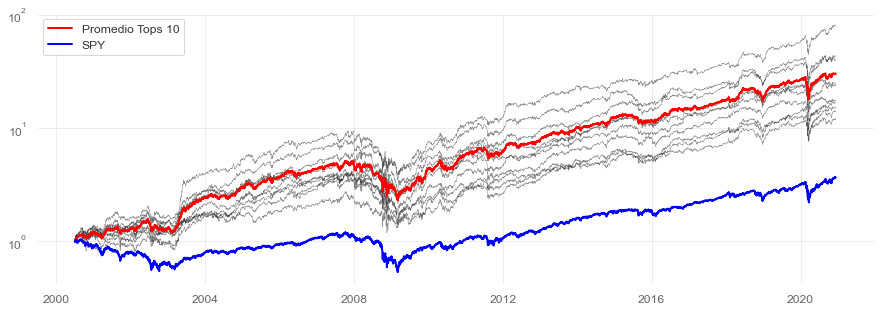

In [24]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,5))

for columna in resumen.columns:
    ax.plot(resumen[columna], 'k', alpha=0.5, lw=0.5)
    ax.set_yscale('log')

ax.plot(resumen.iloc[:,:-1].mean(axis=1), 'red', lw=2, label='Promedio Tops 10')
ax.plot(spy['rendimiento_acum'], 'blue', lw=2, label='SPY')

ax.legend()
ax.plot()

In [25]:
estrategia = resumen.iloc[:,:-1].mean(axis=1) 
estrategia

Date
2000-07-03     1.012607
2000-07-05     1.017270
2000-07-06     1.024215
2000-07-07     1.028332
2000-07-10     1.030391
                ...    
2020-12-07    30.152994
2020-12-08    30.070457
2020-12-09    29.976993
2020-12-10    30.031158
2020-12-11    29.902785
Length: 5118, dtype: float64

In [26]:
qs.extend_pandas()
pd.options.display.max_columns=13
qs.stats.monthly_returns(estrategia)

,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,EOY
2000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.073460,0.050236,-0.003402,-0.016075,0.006200,0.079107,0.191270
2001,-0.035812,-0.042609,-0.014719,0.076669,0.053027,0.019456,0.021942,-0.004025,-0.057696,0.014019,-0.010599,0.045234,0.069342
2002,0.012752,-0.016806,0.043475,0.097050,0.008221,0.020920,-0.120927,0.039426,-0.059146,-0.019048,-0.019754,0.032389,0.024641
2003,-0.046639,0.009939,0.076340,0.199478,0.167845,0.005152,0.096361,0.020198,0.038664,0.038519,0.032816,0.036435,0.655274
2004,-0.003392,0.073726,-0.027272,-0.043154,0.031321,0.022581,-0.028718,-0.016892,0.050244,0.027462,0.062271,0.087194,0.233561
2005,0.007172,0.046081,-0.025418,-0.069618,0.058071,0.054756,0.059426,0.005844,0.053223,-0.045740,0.022001,0.030331,0.197054
2006,0.040387,0.047915,0.056712,-0.009001,-0.053037,0.006414,-0.005546,0.017609,0.013778,0.019814,0.047518,-0.000022,0.186036
2007,0.026182,-0.005228,0.024916,0.015656,0.035975,-0.007457,-0.046159,0.012497,0.074299,0.025352,-0.029655,0.021954,0.160802
2008,-0.078580,-0.030246,0.013844,0.018229,0.003281,-0.099668,-0.049081,-0.007121,-0.111588,0.006109,-0.158279,0.045200,-0.363583
2009,-0.077757,-0.131050,0.048209,0.075588,0.030420,0.015597,0.082775,0.049160,0.103748,-0.115909,0.118219,0.191513,0.380612


In [27]:
estrategia = resumen.iloc[:,:-1].mean(axis=1) 
benchmark = spy['rendimiento_acum']
qs.reports.metrics(estrategia, benchmark, mode='full')

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2000-07-03  2000-07-03
End Period                 2020-12-11  2020-12-11
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          2,853.05%   271.90%
CAGR%                      18.0%       6.63%
Sharpe                     0.87        0.43
Sortino                    1.24        0.6
Max Drawdown               -55.24%     -55.19%
Longest DD Days            924         2241
Volatility (ann.)          21.88%      19.78%
R^2                        0.64        0.64
Calmar                     0.33        0.12
Skew                       -0.36       -0.03
Kurtosis                   9.52        12.79

Expected Daily %           0.07%       0.03%
Expected Monthly %         1.39%       0.54%
Expected Yearly %          17.49%      6.45%
Kelly Criterion            5.69%       1.87%
Risk of Ruin               0.0%   

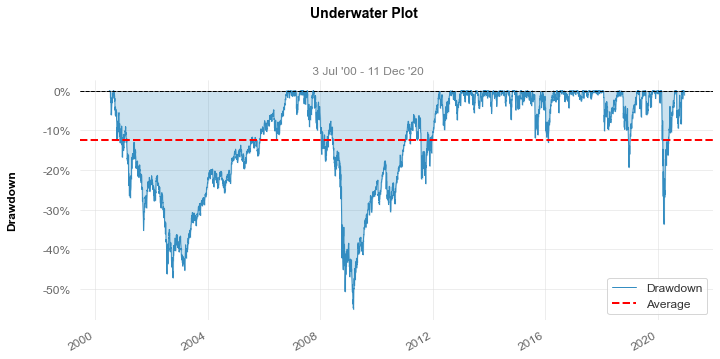

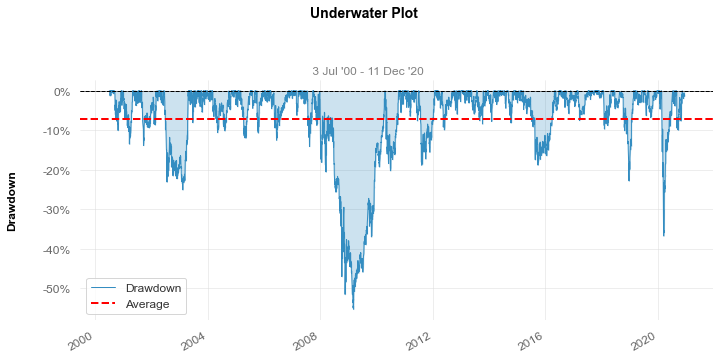

In [28]:
qs.plots.drawdown(benchmark)
qs.plots.drawdown(estrategia)

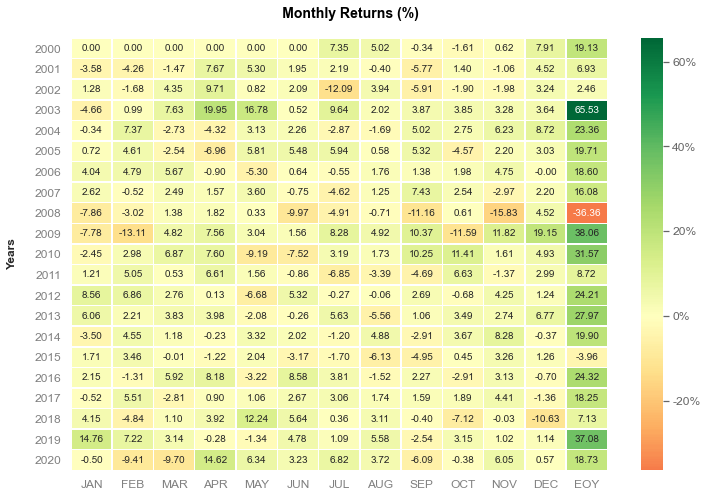

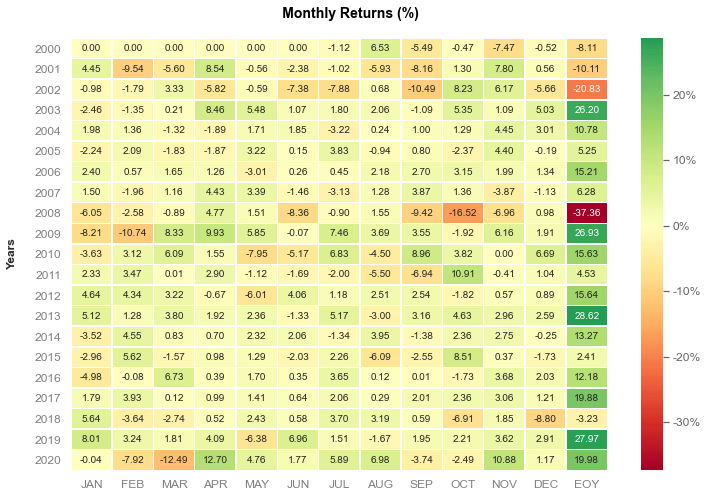

In [29]:
qs.plots.monthly_returns(estrategia, eoy=True)
qs.plots.monthly_returns(benchmark, eoy=True)

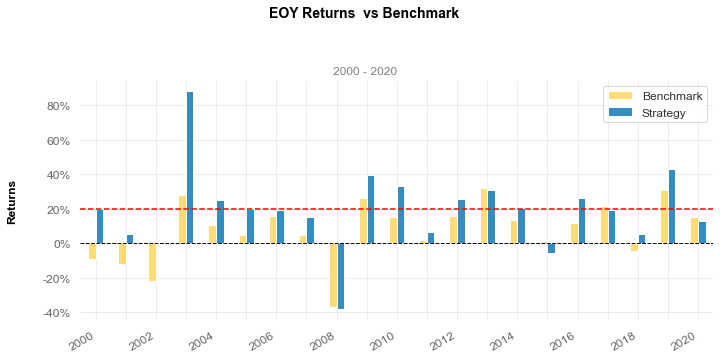

In [30]:
qs.plots.yearly_returns(estrategia, benchmark)

In [31]:
RiskFree = pd.DataFrame(index=estrategia.index)
RiskFree = 0.0001 
EstrategiaPareto = estrategia.pct_change()*0.2 + RiskFree*0.8

EstrategiaPareto

Date
2000-07-03         NaN
2000-07-05    0.001001
2000-07-06    0.001445
2000-07-07    0.000884
2000-07-10    0.000480
                ...   
2020-12-07    0.000792
2020-12-08   -0.000467
2020-12-09   -0.000542
2020-12-10    0.000441
2020-12-11   -0.000775
Length: 5118, dtype: float64

In [32]:
qs.reports.metrics(EstrategiaPareto, benchmark, mode='full')

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2000-07-03  2000-07-03
End Period                 2020-12-11  2020-12-11
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          220.48%     271.9%
CAGR%                      5.86%       6.63%
Sharpe                     1.33        0.43
Sortino                    1.93        0.6
Max Drawdown               -10.9%      -55.19%
Longest DD Days            705         2241
Volatility (ann.)          4.38%       19.78%
R^2                        0.64        0.64
Calmar                     0.54        0.12
Skew                       -0.36       -0.03
Kurtosis                   9.52        12.79

Expected Daily %           0.02%       0.03%
Expected Monthly %         0.47%       0.54%
Expected Yearly %          5.7%        6.45%
Kelly Criterion            10.62%      0.67%
Risk of Ruin               0.0%    

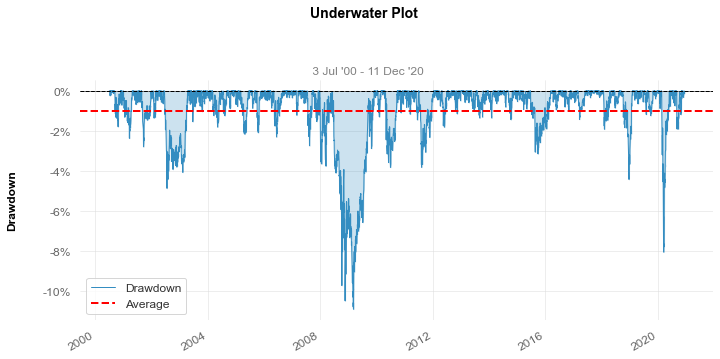

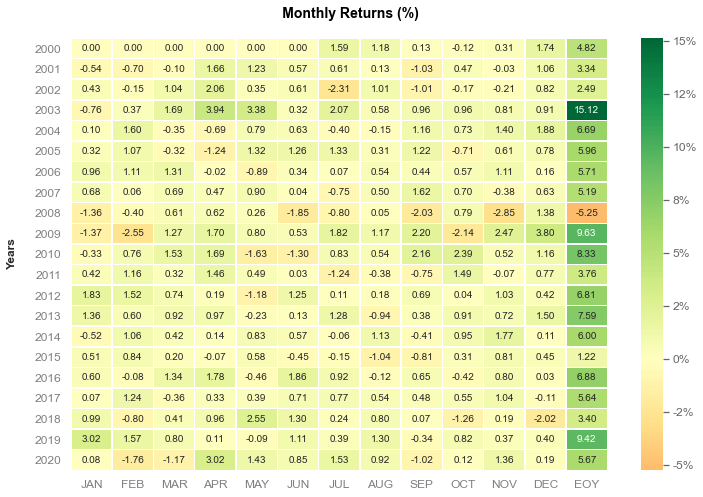

In [33]:
qs.plots.drawdown(EstrategiaPareto)
qs.plots.monthly_returns(EstrategiaPareto, eoy=True)

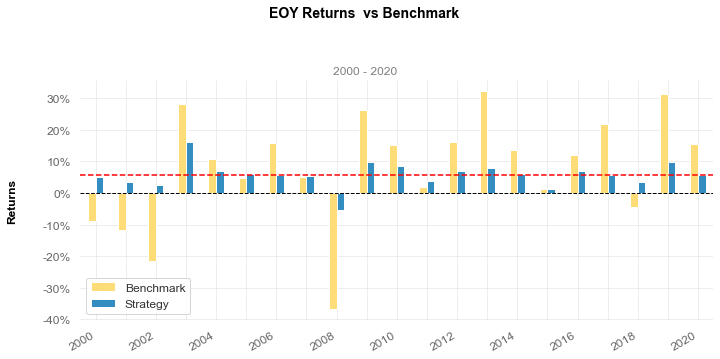

In [34]:
qs.plots.yearly_returns(EstrategiaPareto, benchmark)

                           Strategy
-------------------------  ----------
Start Period               2000-07-03
End Period                 2020-12-11
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          220.48%
CAGR%                      5.86%
Sharpe                     1.33
Sortino                    1.93
Max Drawdown               -10.9%
Longest DD Days            705
Volatility (ann.)          4.38%
Calmar                     0.54
Skew                       -0.36
Kurtosis                   9.52

Expected Daily %           0.02%
Expected Monthly %         0.47%
Expected Yearly %          5.7%
Kelly Criterion            12.34%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.43%
Expected Shortfall (cVaR)  -0.43%

Payoff Ratio               0.99
Profit Factor              1.28
Common Sense Ratio         1.31
CPC Index                  0.71
Tail Ratio                 1.02
Outlier Win Ratio          3.85
Outlier Loss Ratio         4.0

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2007-12-27,2009-03-09,2009-12-01,705,-10.899224,-10.278936
2,2020-02-20,2020-03-18,2020-06-01,102,-8.049334,-7.786230
3,2002-06-18,2002-07-23,2003-04-17,303,-4.865817,-4.288307
4,2018-09-19,2018-12-24,2019-02-06,140,-4.421801,-3.979675
5,2010-04-26,2010-07-02,2010-09-29,156,-3.814483,-3.654358


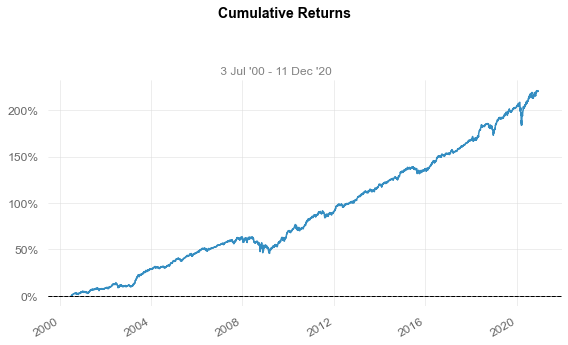

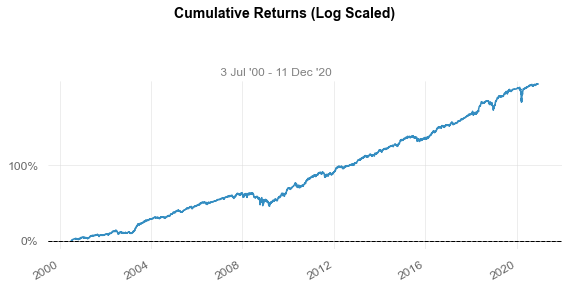

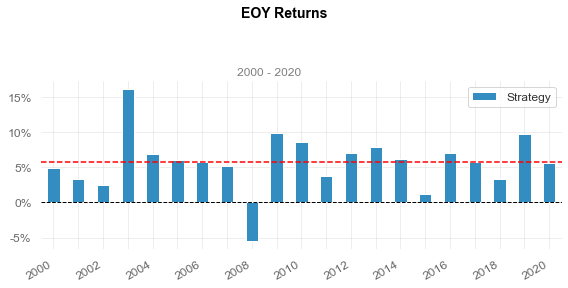

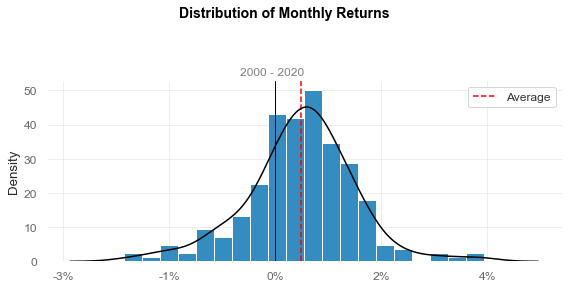

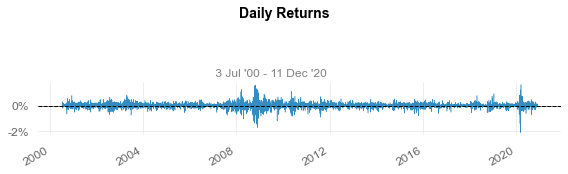

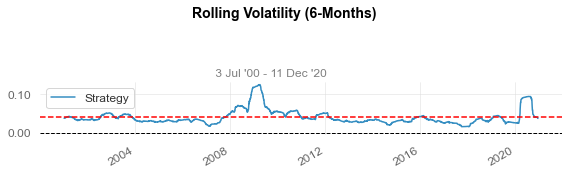

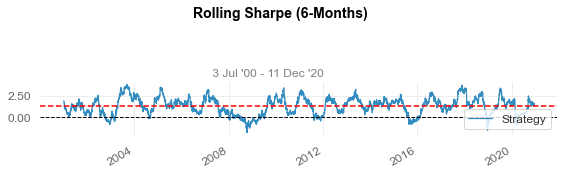

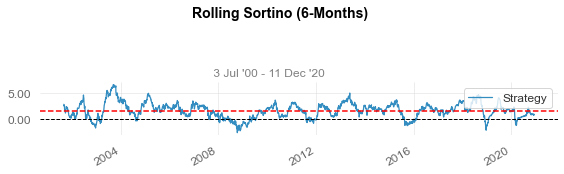

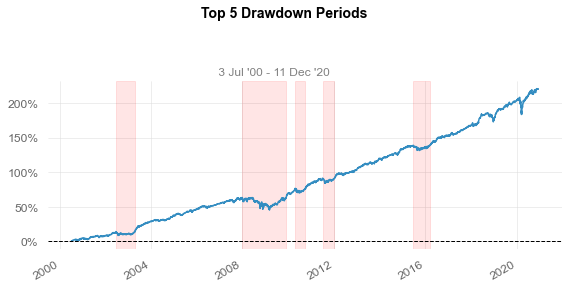

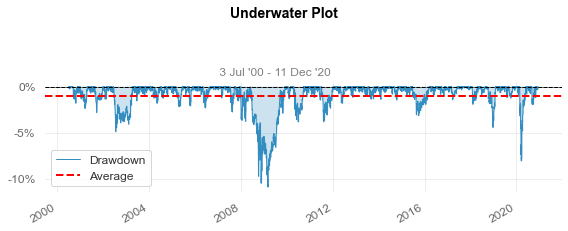

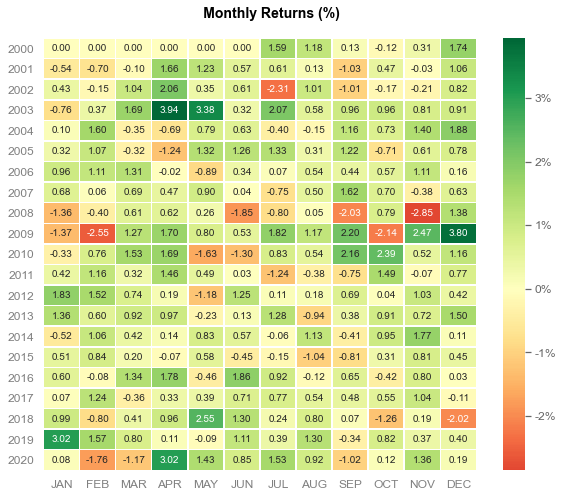

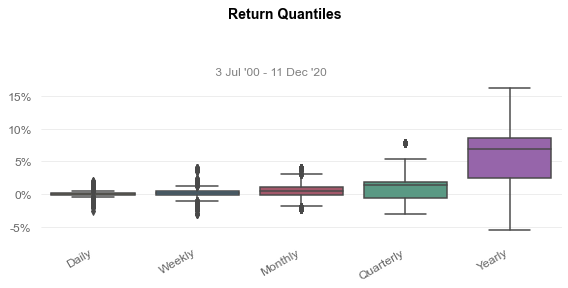

In [35]:
qs.reports.full(EstrategiaPareto)